## Imports

In [117]:
import math,random
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset,dataloader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np



## Variables

In [118]:
IMG_SIZE = 32
EMB_SIZE = 32
ATTENTION_HEADS = 4
BATCH_SIZE =  32
EPOCHS = 70
LR =3e-3
TEMPERATURE = 0.05
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Synthetic data

In [119]:
colors = ['red','green','blue','yellow','purple','orange','pink','brown','gray',]
shapes = ['square','circle','triangle']
positions = ['left', 'center','right','top','bottom','top-left','top-right','bottom-left','bottom-right']

## drawing image shapes

In [120]:
from PIL import Image, ImageDraw

def draw_sample(color, shape, position, img_size=128):
    img = Image.new('RGB', (img_size, img_size), (255, 255, 255))
    draw = ImageDraw.Draw(img)
    margin = 6
    content_area_size = img_size - (2 * margin) # Size of the square where shapes can be drawn

    # Define a default shape size to be drawn within the content area
    shape_width = content_area_size // 2
    shape_height = content_area_size // 2

    # Calculate base coordinates for the shape, assuming it starts at margin
    base_x0 = margin
    base_y0 = margin

    if 'left' in position:
        x0 = base_x0
        x1 = base_x0 + shape_width
    elif 'right' in position:
        x0 = base_x0 + content_area_size - shape_width
        x1 = base_x0 + content_area_size
    else:
        x0 = base_x0 + (content_area_size - shape_width) // 2
        x1 = x0 + shape_width

    if 'top' in position:
        y0 = base_y0
        y1 = base_y0 + shape_height
    elif 'bottom' in position:
        y0 = base_y0 + content_area_size - shape_height
        y1 = base_y0 + content_area_size
    else:
        y0 = base_y0 + (content_area_size - shape_height) // 2
        y1 = y0 + shape_height

    shape_bounds = [x0, y0, x1, y1]

    if shape == 'circle':
        draw.ellipse(shape_bounds, fill=color, outline='black')
    elif shape == 'square':
        draw.rectangle(shape_bounds, fill=color, outline='black')
    else:
        triangle_points = [
            (x0 + (x1 - x0) // 2, y0), # Top-center point
            (x0, y1),                   # Bottom-left point
            (x1, y1)                    # Bottom-right point
        ]
        draw.polygon(triangle_points, fill=color, outline='black')

    return img

## Class for building the dataset

In [121]:


class ShapesDataset():
    def __init__(self, colors, shapes, positions):
        self.images = []
        self.captions = []
        self.colors = colors
        self.shapes = shapes
        self.positions = positions

        for c in self.colors:
            for s in self.shapes:
                for p in self.positions:
                    img = draw_sample(c, s, p)
                    cap = f"{c} {s} {p}"

                    # Convert PIL to Tensor (C, H, W) and normalize
                    img_tensor = torch.from_numpy(np.asarray(img)).permute(2, 0, 1).float() / 255.0
                    self.images.append(img_tensor)
                    self.captions.append(cap)

        self.vocab, self.word2idx = self.build_vocab(self.captions)

    def build_vocab(self, texts):
        # Extract unique words and sort for consistency
        words = sorted({w for t in texts for w in t.split()})
        vocab = ['[CLS]'] + words
        w2i = {w: i for i, w in enumerate(vocab)}
        return vocab, w2i

    def encode_text(self, text):
        toks = [self.word2idx['[CLS]']] + [self.word2idx[w] for w in text.split()]
        return torch.tensor(toks, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.encode_text(self.captions[idx])

## Create the full dataset

In [122]:
full_ds = ShapesDataset(colors, shapes, positions)
VOCAB_SIZE = len(full_ds.vocab)
print(VOCAB_SIZE)

22


## Train val

In [123]:
total_len = len(full_ds)
train_size = int(0.8 * total_len)
val_size = total_len - train_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

In [124]:
train_loader = dataloader.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = dataloader.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

['[CLS]', 'purple', 'square', 'bottom-right']


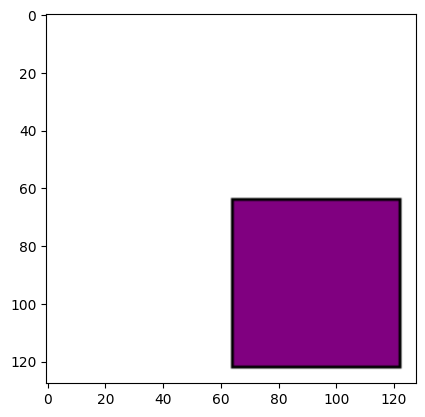

In [125]:
# display a sample point
imgs, captions = next(iter(train_loader))
idx = random.randint(0, len(imgs)-1)
img = (imgs[idx].permute(1,2,0).numpy()*255).astype(np.uint8)

cap_tokens = captions[idx].tolist()
cap_words = [full_ds.vocab[t] for t in cap_tokens]
print(cap_words)
plt.imshow(img)

## Image encoder

In [126]:
class ImageEncoder(nn.Module):
  def __init__(self,embed_dim = EMB_SIZE):
    super().__init__()
    self.convolutions = nn.Sequential(
        nn.Conv2d(3,32,3,2,1),
        nn.ReLU(),
        nn.Conv2d(32,64,3,2,1),
        nn.ReLU(),
        nn.Conv2d(64,128,3,2,1),
        nn.ReLU(),
        nn.Conv2d(128,256,3,2,1),
        nn.ReLU(),
    )


    self.projection = nn.Linear(256,embed_dim)
    self.layernorm1 = nn.LayerNorm(embed_dim)

  def forward(self,x):
    x = self.convolutions(x)
    x = x.mean(dim = [2,3])
    x = self.projection(x)
    x = F.normalize(self.layernorm1(x),dim = 1)
    return x

## Text Encoder

In [127]:
class TextEncoder(nn.Module):
  def __init__(self,embed_dim = EMB_SIZE,num_heads = ATTENTION_HEADS, vocab_size = VOCAB_SIZE,context_window = 4):
    super().__init__()
    self.token_embedding = nn.Embedding(vocab_size,embed_dim)
    self.position_embedding = nn.Embedding(100,embed_dim)
    self.mha = nn.MultiheadAttention(embed_dim , num_heads, batch_first=True)
    self.projection = nn.Linear(embed_dim,embed_dim)
    self.norm = nn.LayerNorm(embed_dim)

  def forward(self,toks):
    N,L = toks.shape
    position_emb_ids = torch.arange(L,device = toks.device).unsqueeze(0).expand(N,L)
    position_embedding_vectors = self.position_embedding(position_emb_ids)
    token_embedding_vectors =  self.token_embedding(toks)
    x = token_embedding_vectors + position_embedding_vectors
    # MultiheadAttention expects (batch_size, sequence_length, embed_dim) with batch_first=True
    attn_output, _ = self.mha(x, x, x)
    # Extract output for the [CLS] token (first token in the sequence)
    x = attn_output[:,0]
    x = self.projection(x)
    x = F.normalize(self.norm(x),dim = 1)
    return x

## CLIP LOSS

In [128]:
def clip_loss(img_emb,txt_emb,temperature = TEMPERATURE):
  logits = img_emb @ txt_emb.T / temperature
  targets =  torch.arange(img_emb.size(0),device = logits.device)
  loss_i = F.cross_entropy(logits,targets)
  loss_t = F.cross_entropy(logits.T,targets)
  return ((loss_t+loss_i)/2.0)

## Model

In [129]:
img_enc =  ImageEncoder().to(device)
text_enc = TextEncoder().to(device)
params = list(img_enc.parameters()) + list(text_enc.parameters())
optimizer = torch.optim.Adam(params,lr = LR)


# Training

In [130]:
def train_epoch(image_encoder, text_encoder, train_loader, optimizer, temperature, device):
    image_encoder.train()
    text_encoder.train()
    total_loss = 0.0

    for imgs, captions in train_loader:
        imgs = imgs.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()

        img_emb = image_encoder(imgs)
        txt_emb = text_encoder(captions)

        loss = clip_loss(img_emb, txt_emb, temperature)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [131]:
def evaluate_epoch(image_encoder, text_encoder, val_loader, temperature, device):
    image_encoder.eval()
    text_encoder.eval()
    total_loss = 0.0

    with torch.no_grad():
        for imgs, captions in val_loader:
            imgs = imgs.to(device)
            captions = captions.to(device)

            img_emb = image_encoder(imgs)
            txt_emb = text_encoder(captions)

            loss = clip_loss(img_emb, txt_emb, temperature)
            total_loss += loss.item()

    return total_loss / len(val_loader)

In [132]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_loss = train_epoch(img_enc, text_enc, train_loader, optimizer, TEMPERATURE, device)
    val_loss = evaluate_epoch(img_enc, text_enc, val_loader, TEMPERATURE, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

Epoch 1/70: Train Loss = 3.4978, Val Loss = 3.1795
Epoch 2/70: Train Loss = 3.0804, Val Loss = 3.1580
Epoch 3/70: Train Loss = 3.0766, Val Loss = 3.1547
Epoch 4/70: Train Loss = 3.0720, Val Loss = 3.1521
Epoch 5/70: Train Loss = 3.0711, Val Loss = 3.1509
Epoch 6/70: Train Loss = 3.0704, Val Loss = 3.1502
Epoch 7/70: Train Loss = 3.0701, Val Loss = 3.1498
Epoch 8/70: Train Loss = 3.0697, Val Loss = 3.1494
Epoch 9/70: Train Loss = 3.0691, Val Loss = 3.1472
Epoch 10/70: Train Loss = 3.0652, Val Loss = 3.1306
Epoch 11/70: Train Loss = 3.0511, Val Loss = 3.1181
Epoch 12/70: Train Loss = 3.0352, Val Loss = 3.0432
Epoch 13/70: Train Loss = 2.9325, Val Loss = 2.8123
Epoch 14/70: Train Loss = 2.7128, Val Loss = 2.6589
Epoch 15/70: Train Loss = 2.4491, Val Loss = 2.5327
Epoch 16/70: Train Loss = 2.3988, Val Loss = 2.4847
Epoch 17/70: Train Loss = 2.4369, Val Loss = 2.4445
Epoch 18/70: Train Loss = 2.3676, Val Loss = 2.3912
Epoch 19/70: Train Loss = 2.1638, Val Loss = 2.3325
Epoch 20/70: Train Lo

## Evaluation

In [133]:
def calculate_retrieval_accuracy(image_encoder, text_encoder, data_loader, device):
    image_encoder.eval()
    text_encoder.eval()

    all_img_embeddings = []
    all_txt_embeddings = []

    with torch.no_grad():
        for imgs, captions in data_loader:
            imgs = imgs.to(device)
            captions = captions.to(device)

            img_emb = image_encoder(imgs)
            txt_emb = text_encoder(captions)

            all_img_embeddings.append(img_emb)
            all_txt_embeddings.append(txt_emb)

    all_img_embeddings = torch.cat(all_img_embeddings, dim=0)
    all_txt_embeddings = torch.cat(all_txt_embeddings, dim=0)

    similarity_matrix = all_img_embeddings @ all_txt_embeddings.T

    num_samples = similarity_matrix.size(0)

    i2t_top1_correct = 0
    i2t_top5_correct = 0
    for i in range(num_samples):
        _, top_k_txt_indices = torch.topk(similarity_matrix[i, :], k=5, dim=0)

        if i == top_k_txt_indices[0]:
            i2t_top1_correct += 1
        if i in top_k_txt_indices:
            i2t_top5_correct += 1

    i2t_top1_accuracy = (i2t_top1_correct / num_samples) * 100
    i2t_top5_accuracy = (i2t_top5_correct / num_samples) * 100

    t2i_top1_correct = 0
    t2i_top5_correct = 0
    for i in range(num_samples):
        _, top_k_img_indices = torch.topk(similarity_matrix[:, i], k=5, dim=0)

        if i == top_k_img_indices[0]:
            t2i_top1_correct += 1
        if i in top_k_img_indices:
            t2i_top5_correct += 1

    t2i_top1_accuracy = (t2i_top1_correct / num_samples) * 100
    t2i_top5_accuracy = (t2i_top5_correct / num_samples) * 100

    return i2t_top1_accuracy, i2t_top5_accuracy, t2i_top1_accuracy, t2i_top5_accuracy

In [134]:
i2t_top1, i2t_top5, t2i_top1, t2i_top5 = calculate_retrieval_accuracy(img_enc, text_enc, val_loader, device)

print(f"Image-to-Text Retrieval: Top-1 Accuracy = {i2t_top1:.2f}%, Top-5 Accuracy = {i2t_top5:.2f}%")
print(f"Text-to-Image Retrieval: Top-1 Accuracy = {t2i_top1:.2f}%, Top-5 Accuracy = {t2i_top5:.2f}%")

Image-to-Text Retrieval: Top-1 Accuracy = 44.90%, Top-5 Accuracy = 97.96%
Text-to-Image Retrieval: Top-1 Accuracy = 40.82%, Top-5 Accuracy = 93.88%


## Display Sample Prediction



True Caption: yellow circle top
Predicted Caption: yellow circle left


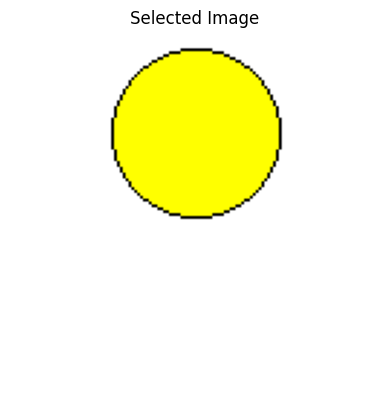

In [135]:
img_enc.eval()
text_enc.eval()

random_idx = random.randint(0, len(val_ds) - 1)
selected_img_tensor, true_caption_tokens = val_ds[random_idx]

selected_img_tensor = selected_img_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    img_emb = img_enc(selected_img_tensor)

all_text_embeddings_list = []

with torch.no_grad():
    for i in range(len(full_ds)):
        _, caption_tokens = full_ds[i]
        caption_tokens = caption_tokens.unsqueeze(0).to(device)
        txt_emb = text_enc(caption_tokens)
        all_text_embeddings_list.append(txt_emb)

all_text_embeddings = torch.cat(all_text_embeddings_list, dim=0)

similarities = img_emb @ all_text_embeddings.T

predicted_caption_idx = torch.argmax(similarities).item()

predicted_caption = full_ds.captions[predicted_caption_idx]

display_img = (selected_img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
true_caption_words = [full_ds.vocab[t.item()] for t in true_caption_tokens]
print(f"True Caption: {' '.join(true_caption_words[1:])}") # Skip [CLS]

print(f"Predicted Caption: {predicted_caption}")

plt.imshow(display_img)
plt.axis('off')
plt.title('Selected Image')
plt.show()